## Looking at trends in environmental compliance, inspections, and enforcement
This notebook draws on data in ECHO to compare EPA regions in terms of compliance, inspections, and enforcements, across all programs (Clean Water Act, Clean Air Act, and the Resource Conservation and Recovery Act).

We will be asking:
- Are more recently inspected facilities more likely to be out of compliance?
- Have compliance and inspection trends declined? _TBD_

---

### First, let's import some libraries

In [1]:
import requests
import csv
import json
from statistics import *
from collections import Counter
import datetime

import urllib.parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium

### Next, we'll prepare for our analysis
We'll go through each EPA region (there are 10) covering the country, and pull basic enforcement, inspections, and compliance data for each major facility regulated within that region. 

In [2]:
sql = "select REGISTRY_ID, FAC_NAME, FAC_LAT, FAC_LONG, FAC_3YR_COMPLIANCE_HISTORY," + \
    " FAC_INFORMAL_COUNT, FAC_FORMAL_ACTION_COUNT," + \
    " FAC_DAYS_LAST_INSPECTION, FAC_DATE_LAST_INSPECTION, FAC_INSPECTION_COUNT" + \
    " from ECHO_EXPORTER where FAC_MAJOR_FLAG = 'Y'" #where \
    #" FAC_EPA_REGION  = 3 "
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)

data = pd.read_csv(data_location, encoding='iso-8859-1', header = 0)
data.set_index("REGISTRY_ID", inplace=True)
data

,FAC_NAME,FAC_LAT,FAC_LONG,FAC_3YR_COMPLIANCE_HISTORY,FAC_INFORMAL_COUNT,FAC_FORMAL_ACTION_COUNT,FAC_DAYS_LAST_INSPECTION,FAC_DATE_LAST_INSPECTION,FAC_INSPECTION_COUNT
REGISTRY_ID,,,,,,,,,
1.100072e+11,SOUTHERN NATURAL GAS,33.599490,-86.253990,____________,0,0,216.0,09/30/2019,5
1.100046e+11,ALL COATINGS CO INC,41.131110,-80.711120,VVSSSSSSS___,3,2,808.0,02/15/2018,4
1.100204e+11,JAS W. GLOVER 0464,21.968056,-159.450277,____________,0,0,2166.0,05/29/2014,0
1.100095e+11,SABINE PASS GAS PLANT,29.756611,-93.645158,U___________,0,1,823.0,01/31/2018,2
1.100705e+11,"GLENDALE ENERGY, LLC",33.536450,-112.302670,____________,0,0,221.0,09/25/2019,1
1.100005e+11,MAXIMUS COFFEE GROUP,29.745800,-95.337500,_______UV___,0,1,251.0,08/26/2019,2
1.100438e+11,FREDERICK COUNTY REGIONAL LANDFILL,39.141050,-78.099050,____________,0,0,508.0,12/12/2018,3
1.100013e+11,MIDAMERICAN ENERGY CO - GEORGE NEAL NORTH,42.327420,-96.367819,VV__VVVV____,0,0,482.0,01/07/2019,4
1.100272e+11,CITY OF CEDAR FALLS - MUNICIPAL WATER UTILITY,42.498590,-92.415610,____________,0,0,472.0,01/17/2019,3


### How many facilities are we talking about?

In [3]:
data.shape[0]

25299

### Now we dive in. Our question: Are more recently inspected facilities more likely to be out of compliance?
We'll start parsing the data by timeframe, for more detailed analysis later on. First, we'll select only facilities that have had inspections over the past five years. Some haven't!

In [4]:
inspected = data[(data["FAC_INSPECTION_COUNT"] > 0)]
print(str(data.shape[0]-inspected.shape[0])+" facilities haven't had inspections in the past five years.")

5971 facilities haven't had inspections in the past five years.


### Here we'll focus in on facilities that have been more recently inspected 
We define that as having gone fewer days since inspection than the median of all facilities)

When we look at compliance, we are looking at Quarter 10 of EPA's dataset. This is a relative definition, Quarter 10 being 2 quarters ago (i.e. Oct-Dec 2019)

RECENTLY INSPECTED FACILITIES: those who last inspection was within the median last inspection date of all facilities. That is, within 346.0 days prior to when SBU's copy of ECHO was last updated
Facilities in significant non-compliance: 12.11%
Facilities in violation: 20.8%
Facilities with no violation: 65.25%
Facilities unknown status: 1.84%


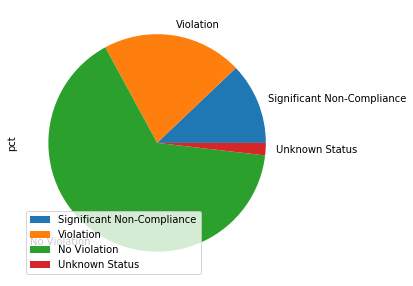

In [7]:
medInspectionDays = inspected["FAC_DAYS_LAST_INSPECTION"].median()
recentlyInspected = inspected[(inspected['FAC_DAYS_LAST_INSPECTION']) < medInspectionDays]

# Percents of facilities - compliance alongside inspections....based on quarter 10 in ECHO data (could adjust)
SNC_RI=(recentlyInspected[(recentlyInspected['FAC_3YR_COMPLIANCE_HISTORY'].str[9:10:1] == "S")].shape[0] /  recentlyInspected.shape[0] ) * 100
Violation_RI=(recentlyInspected[(recentlyInspected['FAC_3YR_COMPLIANCE_HISTORY'].str[9:10:1] == "V")].shape[0] /  recentlyInspected.shape[0] ) * 100
NV_RI=(recentlyInspected[(recentlyInspected['FAC_3YR_COMPLIANCE_HISTORY'].str[9:10:1] == "_")].shape[0] /  recentlyInspected.shape[0] ) * 100
U_RI=(recentlyInspected[(recentlyInspected['FAC_3YR_COMPLIANCE_HISTORY'].str[9:10:1] == "U")].shape[0] /  recentlyInspected.shape[0] ) * 100

avgFormalActions_RI=recentlyInspected['FAC_FORMAL_ACTION_COUNT'].mean()
avgInformalActions_RI=recentlyInspected['FAC_INFORMAL_COUNT'].mean()

print("RECENTLY INSPECTED FACILITIES: those who last inspection was within the median last inspection date of all facilities. That is, within "+str(medInspectionDays)+" days prior to when SBU's copy of ECHO was last updated") 
print("Facilities in significant non-compliance: "+str(round(SNC_RI,2))+"%")
print("Facilities in violation: "+str(round(Violation_RI,2))+"%")
print("Facilities with no violation: "+str(round(NV_RI,2))+"%")
print("Facilities unknown status: "+str(round(U_RI,2))+"%")

### What about those facilities that have NOT been recently inspected? 
We define that as having gone MORE days since inspection than the median of all facilities

In [9]:
notRecentlyInspected = inspected[(inspected['FAC_DAYS_LAST_INSPECTION']) > medInspectionDays]

# Percents of facilities - compliance alongside inspections....based on quarter 10 in ECHO data (could adjust '9:10:1' below to get some other quarter)
SNC_NRI= (notRecentlyInspected[(notRecentlyInspected['FAC_3YR_COMPLIANCE_HISTORY'].str[9:10:1] == "S")].shape[0] /  recentlyInspected.shape[0] ) * 100
Violation_NRI=(notRecentlyInspected[(notRecentlyInspected['FAC_3YR_COMPLIANCE_HISTORY'].str[9:10:1] == "V")].shape[0] /  recentlyInspected.shape[0] ) * 100
NV_NRI=(notRecentlyInspected[(notRecentlyInspected['FAC_3YR_COMPLIANCE_HISTORY'].str[9:10:1] == "_")].shape[0] /  recentlyInspected.shape[0] ) * 100
U_NRI=(notRecentlyInspected[(notRecentlyInspected['FAC_3YR_COMPLIANCE_HISTORY'].str[9:10:1] == "U")].shape[0] /  recentlyInspected.shape[0] ) * 100

avgFormalActions_NRI=notRecentlyInspected['FAC_FORMAL_ACTION_COUNT'].mean()
avgInformalActions_NRI=notRecentlyInspected['FAC_INFORMAL_COUNT'].mean()

print("NOT RECENTLY INSPECTED FACILITIES: those who last inspection was beyond the median last inspection date of all facilities. That is, greater than "+str(medInspectionDays)+" days prior to when SBU's copy of ECHO was last updated") 
print("Facilities in significant non-compliance: "+str(round(SNC_NRI,2))+"%")
print("Facilities in violation: "+str(round(Violation_NRI,2))+"%")
print("Facilities with no violation: "+str(round(NV_NRI,2))+"%")
print("Facilities unknown status: "+str(round(U_NRI,2))+"%")

NOT RECENTLY INSPECTED FACILITIES: those who last inspection was beyond the median last inspection date of all facilities. That is, greater than 346.0 days prior to when SBU's copy of ECHO was last updated
Facilities in significant non-compliance: 9.54%
Facilities in violation: 18.98%
Facilities with no violation: 69.44%
Facilities unknown status: 1.87%


### Let's now summarize some differences between recently and not recently inspected facilities, in terms of their compliance rates and the enforcement actions EPA and state agencies have taken.
Are more recently inspected facilities more likely to be out of compliance? (Because someone went and looked?)

There are 23.69% more recently inspected facilities in SNC than not recently inspected facilities
There are 9.14% more recently inspected facilities with violations than not recently inspected facilities
There are -6.23% more recently inspected facilities in with no violation than not recently inspected facilities
Facilities more recently inspected have 50.73% more formal actions
Facilities more recently inspected have 37.25% more informal actions


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11fd24f90>,
      dtype=object)

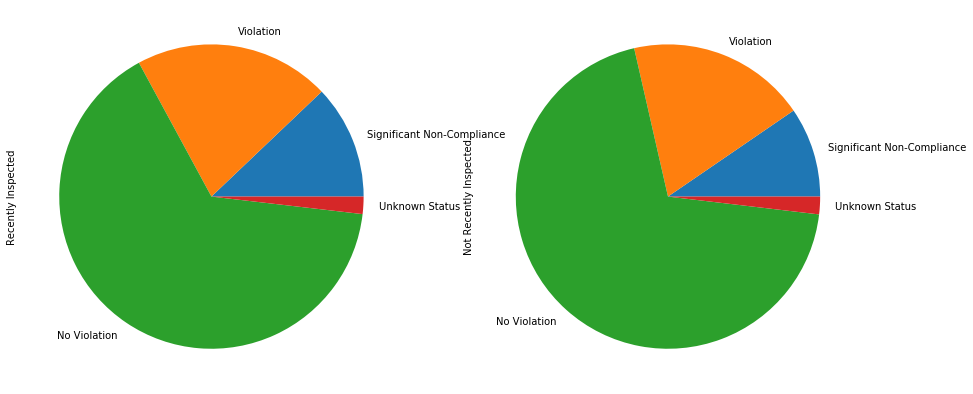

In [12]:
SNCdiff = (SNC_RI-SNC_NRI)/((SNC_NRI+SNC_RI)/2)*100
Vdiff= (Violation_RI-Violation_NRI)/((Violation_NRI+Violation_RI)/2)*100
NVdiff= (NV_RI-NV_NRI)/((NV_NRI+NV_RI)/2)*100
Udiff= (U_RI-U_NRI)/((U_NRI+U_RI)/2)*100
FAdiff=(avgFormalActions_RI-avgFormalActions_NRI)/((avgFormalActions_NRI+avgFormalActions_RI)/2)*100
IAdiff=(avgInformalActions_RI-avgInformalActions_NRI)/((avgInformalActions_NRI+avgInformalActions_RI)/2)*100

print("There are "+str(round(SNCdiff,2))+"% more recently inspected facilities in SNC than not recently inspected facilities")
print("There are "+str(round(Vdiff,2))+"% more recently inspected facilities with violations than not recently inspected facilities")
print("There are "+str(round(NVdiff,2))+"% more recently inspected facilities in with no violation than not recently inspected facilities")

print("Facilities more recently inspected have "+str(round(FAdiff,2))+"% more formal actions")
print("Facilities more recently inspected have "+str(round(IAdiff,2))+"% more informal actions")

df = pd.DataFrame({'Recently Inspected': [SNC_RI, Violation_RI , NV_RI, U_RI],
                  'Not Recently Inspected': [SNC_NRI, Violation_NRI , NV_NRI, U_NRI]},
                  index=['Significant Non-Compliance', 'Violation', 'No Violation', 'Unknown Status'])

p = df.plot.pie(subplots=True, legend=False, figsize=(15, 15))
p

### But are EPA and state agencies even doing inspections on a regular basis?
Here we will analyze whether facilities' most recent inspection interval (days to last inspection) is longer than their average inspection interval over the past 5 years.

In [ ]:
InspectionsOutOfDate=inspected[(inspected["FAC_DAYS_LAST_INSPECTION"] > (1825/inspected["FAC_INSPECTION_COUNT"]))]
percentWithInspectionsOutOfDate=(InspectionsOutOfDate.shape[0]/inspected.shape[0])*100
print(str(round(percentWithInspectionsOutOfDate,2))+"% of facilities haven't been inspected in more than their typical interval")